In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# 폴더 변경
import os
os.chdir("/content/drive/MyDrive/4-2MachineLearning/CNN과제/")

In [ ]:
# CNN을 하는데, 필요한 라이브러리들 import
import numpy as np
import pandas as pd
from pathlib import Path
import os.path


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

In [ ]:
# 이미지의 폴더경로
image_dir = Path('/content/drive/MyDrive/4-2MachineLearning/CNN과제/Images')

In [ ]:
# filepaths : 모든 이미지들의 경로
filepaths = list(image_dir.glob(r'**/*.jpg'))
# 각 파일 경로에서 라벨을 추출, '/' 로 분할하여, 상위 폴더(라벨)을 추출
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
# 파일의 경로와 라벨을 pandas series로 변환, 저장
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
# 파일 경로와, 라벨을 하나의 데이터 프레임으로 합침
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Rockets
1,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Rockets
2,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Rockets
3,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Rockets
4,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Rockets
...,...,...
301,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Carrots
302,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Carrots
303,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Carrots
304,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Carrots


In [ ]:
# 데이터 프레임을 셔플
# 모든 행들이 무작위로 섞임
image_df = image_df.sample(frac=1).reset_index(drop = True)
# 인덱스를 섞은후 처음부터 0으로 다시 라벨링 해줌

In [ ]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Rockets
1,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Carrots
2,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Carrots
3,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Carrots
4,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Carrots
...,...,...
301,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Carrots
302,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Rockets
303,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Rockets
304,/content/drive/MyDrive/4-2MachineLearning/CNNᄀ...,Carrots


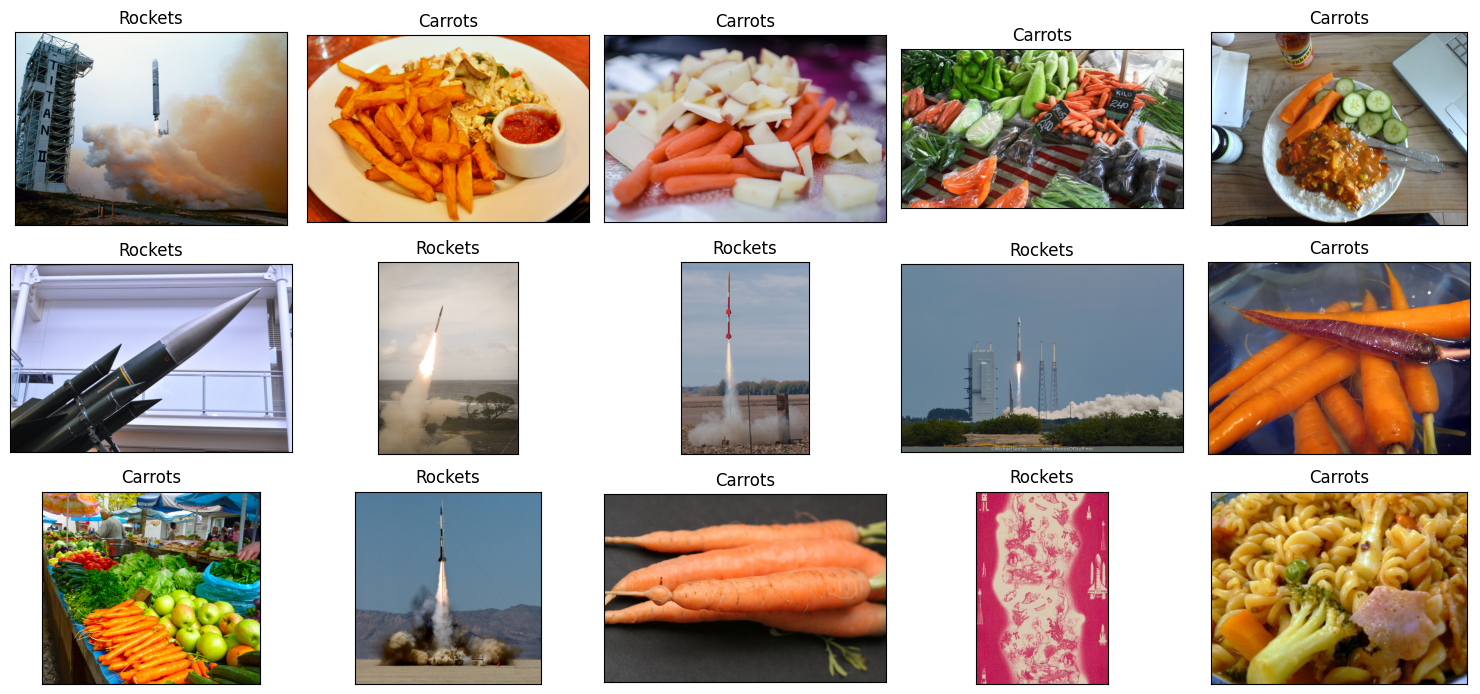

In [ ]:
# 3x5 그리드 형태의 서브플롯 생성
# subplot_kw는 각 서브플롯의 설정을 지정한다.
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
# 서브플롯에 이미지를 표시하는 반복
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    # 라벨을 제목으로 설정
    ax.set_title(image_df.Label[i])
# 서브플롯간의 간격 조정
plt.tight_layout()
plt.show()

In [ ]:
# train set 과, test set을 split, test set의 크기는 0.9, random seed 는 10
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=10)

In [ ]:
train_df.shape

(275, 2)

In [ ]:
# 데이터 전처리, ImageDataGenerator 는 데이터 증강 함수임
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # 픽셀의 값을 0~1 로 rescaling // 정규화, 경사하강법의 안정성, 오버플로우 및 언더플로우 방지, 알고리즘의 수렴성 향상을 꾀함1
    rescale=1./255,
    # 이미지를 수평으로 뒤집는 데이터 증강
    horizontal_flip=True,
    # 이미지를 무작위로 회전 / -40도 ~ 40도
    rotation_range=40,
    # 이미지를 무작위로 가로로 이동 / 이미지 폭의 ~ 20%
    width_shift_range=0.2,
    # 이미지를 무작위로 세로로 이동 / 이미지 높이의 ~ 20%
    height_shift_range=0.2,
    # 이미지를 무작위로 변형
    shear_range=0.2,
    # 이미지를 무작위로 확대
    zoom_range=0.2,
    # validation set는 train set의 20%
    validation_split=0.2
)
# 테스트 데이터의 이미지를 전처리 한느 ImageDataGenerator를 생성
# train data는 증강처리까지 하고, test data는 스케일링만 실행
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [ ]:
# train data 제너레이터를 생성
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df, # 훈련 데이터 지정
    x_col='Filepath', # 이미지 파일 경로가 저장된 열
    y_col='Label', # 라벨 정보가 저장된 열
    target_size=(224, 224), # 이미지 크기 조정
    color_mode='rgb', # 컬러이미지 rgb 사용
    class_mode='categorical', # 다중 클래스 분류 -> categorical
    batch_size=32, # 미니 배치 사이즈 지정
    shuffle=True, # 데이터 무작위로 섞기
    seed=30, # 난수 발생시드
    subset='training'# 훈련데이터 서브셋을 사용 , 훈련데이터 생성
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df, # 훈련 데이터 프레임 지정
    x_col='Filepath', # 이미지 파일 경로 지정
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=30,
    subset='validation' #'validation' 서브셋을 사용하여 검증 데이터 생성
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df, # 테스트 데이터프레임 지정
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False, # 데티어를 섞지 않음, test와 다름
    seed = 30 # 난수 발생 시드
)

Found 220 validated image filenames belonging to 2 classes.
Found 55 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.


In [ ]:
train_images.class_indices

{'Carrots': 0, 'Rockets': 1}

In [ ]:
# Train Data 를 학습할 신경망 쌓기
inputs = tf.keras.Input(shape=(224, 224, 3)) # 이미지의 크기가 224 x 224 이고, rgb 이므로, 224 x 224 x 3
# 1번 레이어, 32개의 필터, 필터의 크기는 3x3, 활성화 함수는 relu
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
# 2번 레이어, 2x2 크기의 맥스 풀링 레이어 추가
x = tf.keras.layers.MaxPool2D(2,2)(x)
# 3번 레이어, 64개의 필터, 필터이 크기는 3x3, 활성화 함수는 relu
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(inputs)
# 4번 레이어, 2x2 크기의 맥스 풀링 레이어 추가
x = tf.keras.layers.MaxPool2D(2,2)(x)
# 5번 레이어, 128개의 필터, 필터의 크기는 3x3, 활성화 함수는 relu
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(inputs)
# 6번 레이어, 2x2 크기의 맥스 풀링 레이어
x = tf.keras.layers.MaxPool2D(2,2)(x)
# 20% 의 드롭 아웃 비율을 가진, 레이어 추가
x = tf.keras.layers.Dropout(0.2)(x)
# 다차원 데이터를 Flatten -> 1차원
x = tf.keras.layers.Flatten()(x)
# Fully connected Layer1 : 256개의 뉴런을 가진, 완전 연결 레이어 추가, 활성화 함수는 relu
x = tf.keras.layers.Dense(256, activation='relu')(x)
# Fully connected Layer2 : 256개의 뉴런을 가진, 완전 연결 레이어 추가, 활성화 함수는 relu
x = tf.keras.layers.Dense(256, activation='relu')(x)
# 결과는, 2개의 뉴런을 가진 출력 레이어, 활성화 함수는 시그모이드
outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)
# 모델 생성.
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer='adam', # 최적화 알고리즘 : adam
    loss='categorical_crossentropy', # 손실함수 : crossentropy
    metrics=['accuracy'] # 모델을 평사할 지표 : accuracy
)

In [ ]:
checkpoint_path = 'models/models/Mymodel.h5'

callbacks = [
    # 손실(cal_loss)을 모니터링, 손실이 10 에폭 동안 줄어들지 않으면,훈련 조기 종료
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    # ReduceLROnPlateau 콜백: 검증 데이터의 손실(val_loss)을 모니터링하며, 손실이 5 에폭 동안 감소하지 않으면 학습률을 0.1배로 감소시킴.
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    # ModelCheckpoint 콜백: 검증 데이터의 손실(val_loss)을 모니터링하며, 손실이 가장 낮을 때 모델의 가중치를 저장, 모델의 가중치만 저장하지 않음
    # 가장 좋은 성능을 보인 모델만 저장
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
# 모델을 fit 하기 시작
history = model.fit(
    train_images, # train image를 사용
    validation_data=val_images, # validation 은 val_image 사용
    epochs=20, # 20에포크 실행
    callbacks=callbacks # 콜백 함수 리스트
)

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 39.1303 - accuracy: 0.4273
Epoch 1: val_loss improved from inf to 5.13499, saving model to models/models/Mymodel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 31s 5s/step - loss: 39.1303 - accuracy: 0.4273 - val_loss: 5.1350 - val_accuracy: 0.7455 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 7.5735 - accuracy: 0.6909
Epoch 2: val_loss did not improve from 5.13499
7/7 [==============================] - 5s 764ms/step - loss: 7.5735 - accuracy: 0.6909 - val_loss: 7.5897 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 3.0817 - accuracy: 0.8318
Epoch 3: val_loss improved from 5.13499 to 0.92446, saving model to models/models/Mymodel.h5
7/7 [==============================] - 24s 4s/step - loss: 3.0817 - accuracy: 0.8318 - val_loss: 0.9245 - val_accuracy: 0.8909 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.8545
Epoch 4: val_loss improved from 0.92446 to 0.64611, saving model to models/models/Mymodel.h5
7/7 [==============================] - 23s 4s/step - loss: 0.5778 - 

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0])) # 테스트 데이터의 손실(loss) 출력
print("Test Accuracy: {:.2f}%".format(results[1] * 100)) # 테스트 데이터의 정확도 출력

    Test Loss: 0.96251
Test Accuracy: 74.19%


In [ ]:
pred = model.predict(test_images) # test 데이터 예측 시작
pred = np.argmax(pred,axis=1) # 각 예측에 대해, 확률값이 가장 높은 클래스의 인덱스 선택

labels = (train_images.class_indices) # 클래스 레이블 사이의 매핑을 가져옴
labels = dict((v,k) for k,v in labels.items()) # 매핑된 클래스 레이블을 딕셔너리로 변환
pred = [labels[k] for k in pred] # 예측된 클래스 인덱스를 클래스 로 변환

1/1 [==============================] - 0s 402ms/step


In [ ]:
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Carrots', 'Rockets', 'Rockets', 'Carrots', 'Rockets']


In [ ]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)  # 실제 테스트 데이터의 클래스 레이블을 리스트로 가져옴
print(classification_report(y_test, pred)) # 분류 모델의 성능 보고서 출력

              precision    recall  f1-score   support

     Carrots       0.62      0.83      0.71        12
     Rockets       0.87      0.68      0.76        19

    accuracy                           0.74        31
   macro avg       0.75      0.76      0.74        31
weighted avg       0.77      0.74      0.75        31



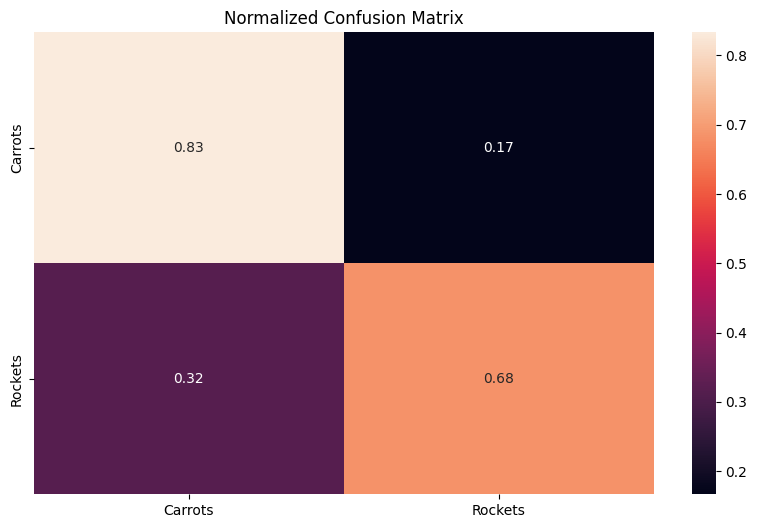

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true') # 혼동 행렬을 계산.
plt.figure(figsize = (10,6)) # 크기 선택
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test))) # 히트맵으로 시각화
plt.title('Normalized Confusion Matrix') # 제목
plt.show()

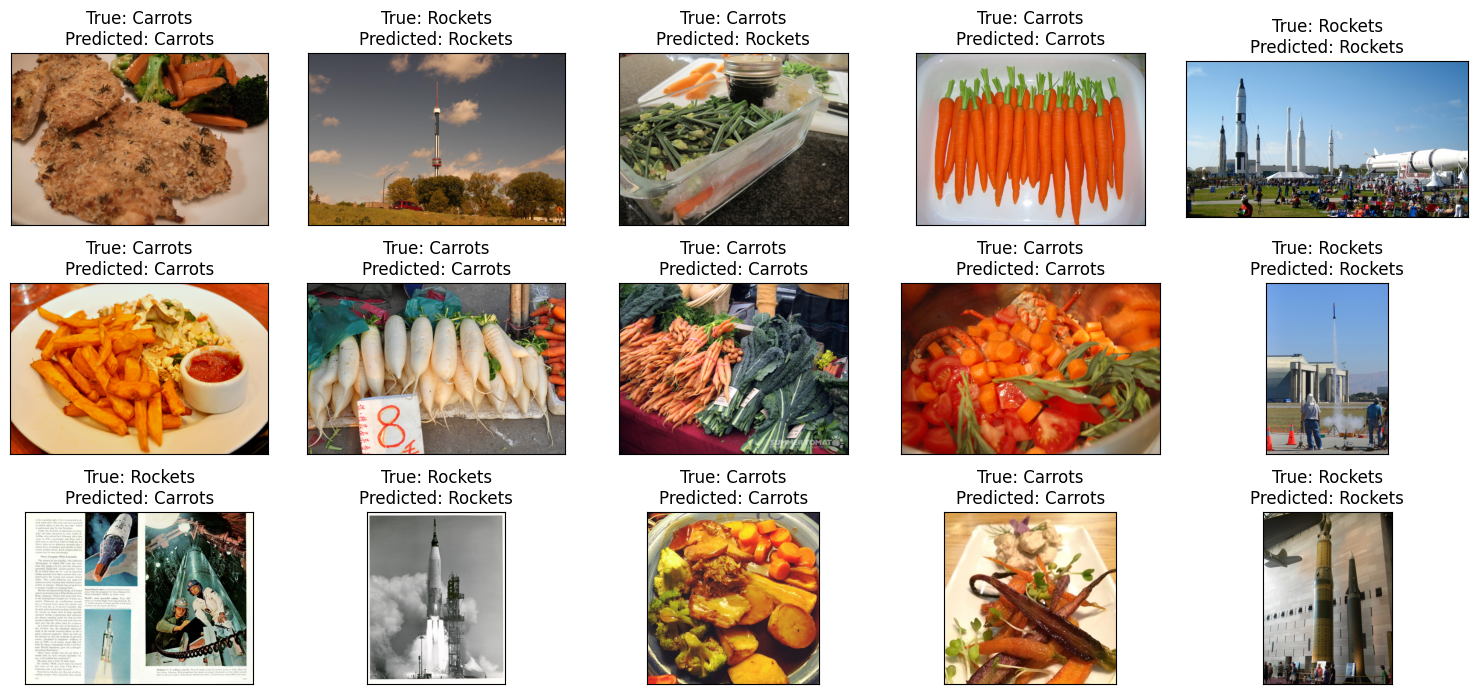

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()